<h1><center>Ingénierie Mathématique 3, Devoir Maison</center></h1>

#### **EL ARGOUBI  EL MEHDI**
#### **ING2 - TD1**

## Question 1 : Un premier modèle

On considère le jeu de données MNIST ci-dessous (les images peuvent être téléchargées via scikit learn ou via keras). On souhaite commencer par entraîner un modèle de régression logistique permettant de différencier les 1 des 0. Pour ce faire on procédera comme suit:

- Extraire à partir des données ci-dessous, les images représentant des $1$ ou des $0$.
- Séparer les données en un ensemble de test et un ensemble d'entraînement (on gardera 10% des données pour l'ensemble test)
- Compléter la fonction "binary_cross_entropy" afin que celle-ci retourne la valeur de l'entropie binaire croisée ainsi que le gradient de cette fonction en une image donnée et pour un vecteur de coefficients de régression $\mathbf{w}$ donne.
- Compléter ensuite la fonction “optimisation" afin qu'elle implémente une descente de gradient sur la fonction d'entropie binaire croisée. On souhaite  renvoyer en sortie le vecteur des coefficients de régression ainsi que (1) le taux de classification (en pourcentage de données correctement classées sur le nombre de données totales) sur les ensembles d'entraînement et de test.  



In [71]:
# Importation des bibliothèques
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

In [72]:
# URL du fichier contenant les données MNIST
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

# Téléchargement du fichier MNIST
path = tf.keras.utils.get_file('mnist.npz', DATA_URL)

# Chargement des données depuis le fichier téléchargé
with np.load(path) as data:
    X = data['x_train']
    y = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

# Affichage des shapes des données pour vérifier
print("Shape des exemples d'entraînement:", X.shape)
print("Shape des labels d'entraînement:", y.shape)
print("Shape des exemples de test:", test_examples.shape)
print("Shape des labels de test:", test_labels.shape)

Shape des exemples d'entraînement: (60000, 28, 28)
Shape des labels d'entraînement: (60000,)
Shape des exemples de test: (10000, 28, 28)
Shape des labels de test: (10000,)


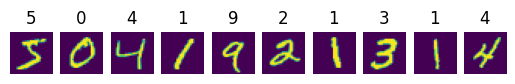

In [73]:
# Visualisation d'un exemplaire d'images et de leurs valeurs avant filtrage
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X[i].reshape(28, 28))
    plt.title(f"{str(y[i])[:10]}")
    plt.axis('off')

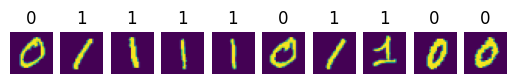

In [74]:
# Filtrage des images pour garder uniquement les classes 0 et 1
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)].astype(int)

# Visualisation d'un exemplaire d'images et de leurs valeurs après filtrage
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X[i].reshape(28, 28))
    plt.title(f"{str(y[i])[:10]}")
    plt.axis('off')

$$X_{norm} = \frac{(X - X_{min})}{(X_{max} - X_{min})} = \frac{X}{255}$$

In [75]:
# Normalisation des données entre 0 et 1 + et aplatir les images
X = X / 255
X = X.reshape(X.shape[0], -1)

In [76]:
# Séparation des données en ensemble d'entraîment (90%) et de test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Les dimensions des ensembles train et test
print("Dimensions de X_train:", X_train.shape)
print("Dimensions de y_train:", y_train.shape)
print("Dimensions de X_test:", X_test.shape)
print("Dimensions de y_test:", y_test.shape)

Dimensions de X_train: (11398, 784)
Dimensions de y_train: (11398,)
Dimensions de X_test: (1267, 784)
Dimensions de y_test: (1267,)


In [77]:
# Nombre de valeurs de classes dans l'ensemble d'entraîment
print("Classe 0:", np.sum(y_train == 0))
print("Classe 1:", np.sum(y_train == 1))

Classe 0: 5320
Classe 1: 6078


In [78]:
# Fonction sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [79]:
# Prédiction par régression logistique
def logistic_regression(X, w):
    return sigmoid(np.dot(X, w))

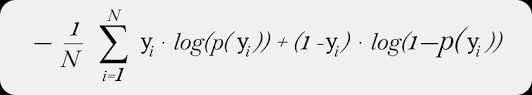

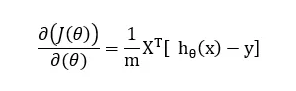

In [80]:
# Binary Cross-Entropy et calcul du gradient
def binary_cross_entropy(X, y, w):
    predictions = logistic_regression(X, w)
    bce_fun = -np.mean(y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8))
    bce_grad = -np.dot(X.T, (y - predictions)) / X.shape[0]
    return bce_fun, bce_grad

In [81]:
# Calcul du taux de classification
def taux_classification(X, y, w):
    predictions = logistic_regression(X, w) >= 0.5
    return np.mean(predictions==y)*100

In [82]:
# Fonction d'optimisation par descente de gradient avec mini-data
def optimisation(w_init, eta, X, y, n_iter, sub_data):
    w_opt = w_init

    for i in range(n_iter):
        bce_loss = 0

        # Itération sur les données par mini-data
        for sub_x in range(0, X.shape[0], sub_data):
            X_i = X[sub_x:sub_x + sub_data]
            y_i = y[sub_x:sub_x + sub_data]

            # Fonction de perte et gradient
            bce_fun, bce_grad = binary_cross_entropy(X_i, y_i, w_opt)

            bce_loss += bce_fun  # Màj de perte totale
            w_opt -= eta * bce_grad # Màj des poids

        # Affichage de la perte toutes les 20 itérations
        if i % 20 == 0:
            print(f"Iteration {i}, BCE Loss: {bce_loss:.4f}")

    # Taux de classification sur l'ensemble d'entraîment et de test
    rate_bce_training = taux_classification(X, y, w_opt)
    rate_bce_test = taux_classification(X_test, y_test, w_opt)

    return w_opt, rate_bce_training, rate_bce_test

In [83]:
W_init = np.random.randn(X_train.shape[1])  # Poids initiaux
eta = 0.001
w_opt, train_accuracy, test_accuracy = optimisation(W_init, eta, X_train, y_train, n_iter = 101, sub_data = 50)

print(f"Accuracy du Train: {train_accuracy:.2f}%")
print(f"Accuracy du Test : {test_accuracy:.2f}%")

Iteration 0, BCE Loss: 533.8853
Iteration 20, BCE Loss: 49.3753
Iteration 40, BCE Loss: 25.2862
Iteration 60, BCE Loss: 17.5349
Iteration 80, BCE Loss: 13.6923
Iteration 100, BCE Loss: 11.3833
Accuracy du Train: 98.61%
Accuracy du Test : 98.82%


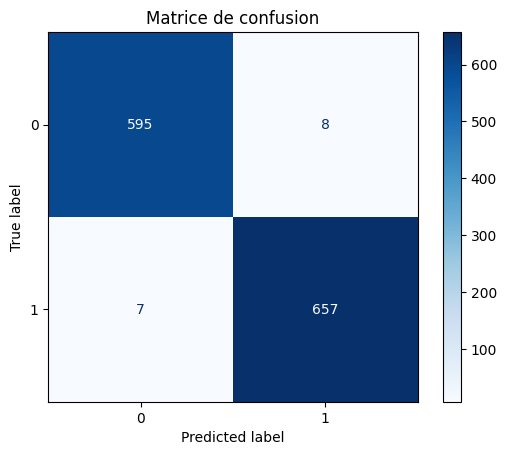

In [84]:
# Matrice de confusion
y_pred_test = (logistic_regression(X_test, w_opt) >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_test)
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap="Blues")
plt.title("Matrice de confusion")
plt.show()

## Question 2 : Un petit réseau convolutif

On souhaite à présent ameliorer le resultat de la question 1 a l'aide d'un réseau convolutionnel. Pour ce faire, on souhaite utiliser la librairie Keras (voir https://keras.io/) et en particulier, le modele de reseau convolutionnel (https://keras.io/api/layers/convolution_layers/). Un réseau convolutionnel fonctionne en "filtrant" les images à l'aide de différents filtres dont les coefficients sont appris lors de l'étape d'entraînement. Un réseau convolutionnel efficace est typiquement constitué d'une succession de couches convolutives et de pooling (voir par exemple https://www.tensorflow.org/tutorials/images/cnn).

Chaque couche convolutive déplace un filtre (dont les coefficients sont fixés lors de l'étape d'entraînement) sur les sorties des couches précédentes


<img src="same_padding_no_strides.gif" alt="stackoverflow.com" width=304 height=142>


Afin de réduire la dimension des sorties des couches successives, on alterne généralement entre des couches convolutives et des couches de pooling (équivalentes à un sous-échantillonnage) qui retiennent pour une région donnée, uniquement les pixels de plus forte intensité (afin de conserver une trace du contraste). Ces couches sont de la forme suivante:


<img src="maxPool.png" alt="stackoverflow.com" width=504 height=142>


In [85]:
# Import des librairies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [86]:
# Redimensionnement des données
X = X.reshape(-1, 28, 28)
y = y.reshape(-1, 1)

In [87]:
# Séparation en train (90%) et test (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Encoder les étiquettes en one-hot
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [88]:
# Création du modèle séquentiel
model = Sequential([])

## Ajouter les couches convolutives et pooling
# 1er couche convolutive
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2))) # Couche de pooling

# 2em couche
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) # Aplatir les sorties pour les couches denses
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,002 (875.01 KB)

 Trainable params: 224,002 (875.01 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.9868 - loss: 0.0452 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 4.1896e-04
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.9996 - loss: 8.8814e-04 - val_accuracy: 1.0000 - val_loss: 2.4307e-05
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 1.5324e-06
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9999 - loss: 5.8782e-04 - val_accuracy: 1.0000 - val_loss: 1.6896e-06
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 1.0000 - loss: 9.4612e-05 - val_accuracy: 1.0000 - val_loss: 7.6444e-07
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 1.0000 - loss: 5.5909e-06 - val_accuracy: 1.0000 - val_loss: 2.8108e-06
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/s

In [90]:
# Évaluation sur l'entraînement et le test
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Taux de classification sur train : {train_acc * 100:.2f}%")
print(f"Taux de classification sur test : {test_acc * 100:.2f}%")

Taux de classification sur train : 100.00%
Taux de classification sur test : 100.00%


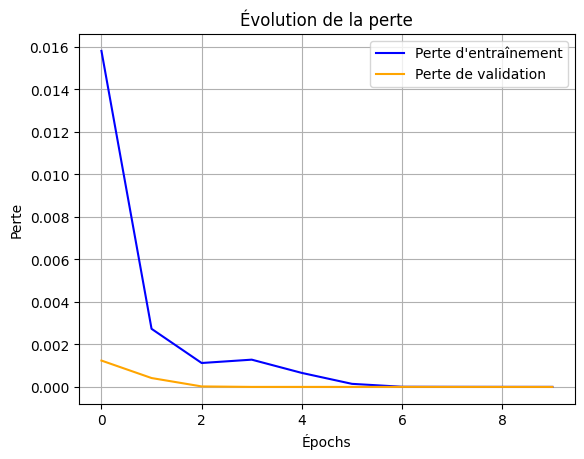

In [91]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Courbe d'évolution de la perte
plt.plot(train_loss, label='Perte d\'entraînement', color='blue')
plt.plot(val_loss, label='Perte de validation', color='orange')
plt.title('Évolution de la perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()
plt.grid(True)

## Question 3 : Astuce du Noyau

On souhaite à présent entraîner un modèle de régression linéaire dans l'espace noyau sur les images de 0 et de 1. Afin d'atteindre cet objectif, on procédera comme suit:

- Sélectionner un sous-ensemble d'équilibre d'images de 0 et de 1 (on commencera par exemple par prendre 50 images du chiffre 0 et 50 images du chiffre 1).
- Compléter la fonction G(x, y) qui renvoie la valeur d'un noyau Gaussien de paramètre sigma, aux points $x$ et $y$.
- Compléter la fonction "optimize" a l'aide d'une descente de gradient dans l'espace noyau afin qu'elle retourne le vecteur des coefficients $\lambda_j$ d'un modele du type
$$y(x) = \sum_{j=1}^N \lambda_j G(x, x_j)$$

- Comme pour la question 2, on souhaite implémenter la fonction "optimize" de façon à ce qu'elle retourne la liste des taux de classification correcte (sur l' ensemble d'entraînement et de test) pour chacune des itérations.


In [92]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# fonction du noyau gaussien
def G(x, y, sigma):

    distance = np.linalg.norm(x - y)**2
    # noyau gaussien
    noyau_gaussien = np.exp(-distance / (2 * sigma**2))
    return noyau_gaussien

gk = G(np.array([1, 2]), np.array([3, 4]), sigma=1)
print(gk)  # Renvoie une valeur entre 0 et 1

0.018315638888734165


In [93]:
# Matrice de noyau
def kernel_matrix(X1, X2, sigma):
      K = np.zeros((X1.shape[0], X2.shape[0]))
      for i in range(X1.shape[0]):
          for j in range(X2.shape[0]):
              K[i, j] = G(X1[i], X2[j], sigma)
      return K

In [94]:
# Optimisation avec descente de gradient
def optimize(X, y, sigma, lr=0.01, iterations=101):
    N = X.shape[0]
    lbda = np.zeros(N)

    K_train = kernel_matrix(X, X, sigma)

    for iter in range(iterations):
        predictions = np.dot(K_train, lbda) # Prédictions sur l'ensemble d'entraînement

        # Descente de gradient
        grad = np.dot(K_train.T, (predictions - y)) / N
        lbda -= lr * grad ## Maj de lambda

        if iter % 20 == 0:
          print(f"Itération {iter}: Norme = {np.linalg.norm(grad):.4f}")

    # Taux de classification
    def predict(X_train, X_test, lbda, sigma):
        K_test = kernel_matrix(X_test, X_train, sigma)
        return np.sign(np.dot(K_test, lbda))

    y_train_pred = predict(X, X, lbda, sigma)
    y_test_pred = predict(X, X_test, lbda, sigma)

    rate_training = np.mean(y_train_pred == y) * 100
    rate_test = np.mean(y_test_pred == y_test) * 100

    return lbda, rate_training, rate_test

In [95]:
def balanced_subset(data, y, n=1000):
    class_0 = np.where(y == 0)[0][:n]
    class_1 = np.where(y == 1)[0][:n]
    indice = np.concatenate([class_0, class_1])
    np.random.shuffle(indice)
    subset_X = X[indice]
    subset_y = y[indice]
    return subset_X, subset_y

In [96]:
# URL du fichier contenant les données MNIST
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

# Téléchargement du fichier MNIST
path = tf.keras.utils.get_file('mnist.npz', DATA_URL)

# Chargement des données depuis le fichier téléchargé
with np.load(path) as data:
    X = data['x_train']
    y = data['y_train']
    test_examples = data['x_test']
    test_labels = data['y_test']

# Normalisation des données
X = X / 255.0

# Masque pour garder juste les 0 et 1
mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]

# Redimensionner les images
X = X.reshape(X.shape[0], -1)

X_subset, y_subset = balanced_subset(X, y)

# Séparation des données en ensembles de train et de test
X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.1, random_state=42)

# Entraînement du modèle noyau gaussien
sigma = 0.1
lbda, rate_training, rate_test = optimize(X_train, y_train, sigma)

print(f"Taux de classification sur l'ensemble train : {rate_training:.2f}%")
print(f"Taux de classification sur l'ensemble test : {rate_test:.2f}%")

Itération 0: Norme = 0.0167
Itération 20: Norme = 0.0167
Itération 40: Norme = 0.0167
Itération 60: Norme = 0.0167
Itération 80: Norme = 0.0167
Itération 100: Norme = 0.0167
Taux de classification sur l'ensemble train : 100.00%
Taux de classification sur l'ensemble test : 98.50%
